Load dataset

In [ ]:
import pandas as pd
import numpy as np
from google.colab import auth
auth.authenticate_user()
import gspread
import gspread_dataframe 
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())
sh = gc.create('ThucNghiemLai_TH4_WnD')

index=0#train


#Load train dataset và tách lấy đặc trưng và cột nhãn
train = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/10set (đủ mã)/AMD_Benign_ver2(tong hop)/train-0.csv", header=None, skiprows=1)
x_train = np.array(train.iloc[:, 3:])
y_train = np.array(train.iloc[:, 2])
del train
#Load val dataset và tách lấy đặc trưng và cột nhãn
val = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/10set (đủ mã)/AMD_Benign_ver2(tong hop)/file-0.csv", header=None, skiprows=1)
x_val = np.array(val.iloc[:, 3:])
y_val = np.array(val.iloc[:, 2])
del val
#Load test dataset và tách lấy đặc trưng và cột nhãn
test = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/10set (đủ mã)/AMD_Benign_ver2(tong hop)/file-0.csv", header=None, skiprows=1)
x_test = np.array(test.iloc[:, 3:])
y_test = np.array(test.iloc[:, 2])
del test

Install the gspread library and create a gg sheet file to record the results

In [ ]:
!pip install --upgrade gspread
!pip install --upgrade gspread-pandas
!pip install --upgrade gspread-dataframe

# from google.colab import auth
# auth.authenticate_user()
# import gspread
# import gspread_dataframe 
# from oauth2client.client import GoogleCredentials

# gc = gspread.authorize(GoogleCredentials.get_application_default())
# sh = gc.create('ThucNghiemLai')

  Found existing installation: gspread 3.0.1
    Uninstalling gspread-3.0.1:
      Successfully uninstalled gspread-3.0.1
  Found existing installation: gspread-dataframe 3.0.8
    Uninstalling gspread-dataframe-3.0.8:
      Successfully uninstalled gspread-dataframe-3.0.8


Functions for plotting, recording results, calculating acc, precision, f1 score, recall,...
**Calculation parameters acc, precision, f1 score,...**

https://en.wikipedia.org/wiki/Confusion_matrix

https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826

When predict we match labels to create confusion matrix. The TN, FN, FP definitions for a label are as shown below:

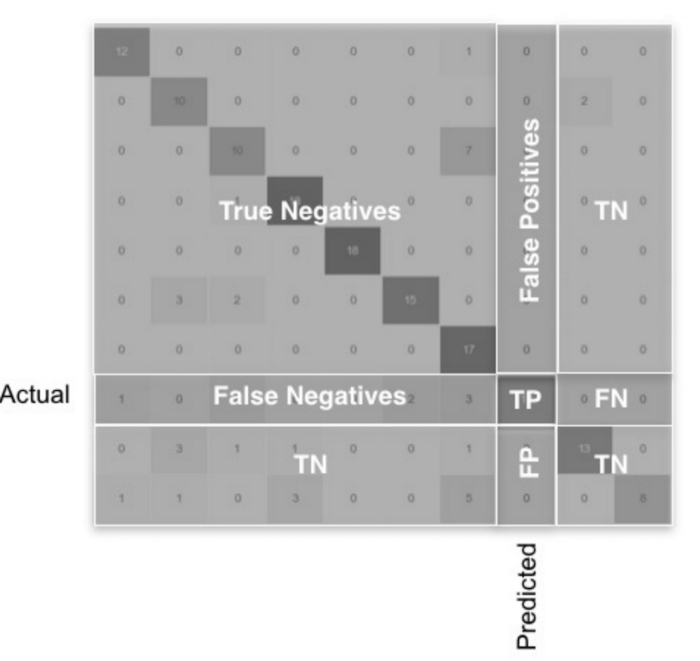




```
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
```

Calculate precision, recall, f1 score, acc for the whole dataset:


* Macros (in the sklearn library with the parameter average="macro"):
Total measure = AVG(Measure of each label)
```
#Precision
pre = np.nansum(TP / (TP + FP))
```

* Weighted (in sklearn library with parameter average="weighted"):
Total measure = Total (Measure of each label * quantity) / Total quantity
```
#Precision
pre = sum(TP) / (sum(TP) + sum(FP)))
```

In [ ]:
import keras
import numpy as np
import pandas as pd
from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.utils import to_categorical
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

def save_plot_acc(history, folder):
  '''Save your acc and loss chart after training'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(20)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.savefig('/content/drive/MyDrive/ThucNghiemLai/{}/acc.png'.format(folder))

  plt.close('all')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def get_report(y_true, y_pred):
  acc = accuracy_score(y_true, y_pred)
  cnf_matrix = confusion_matrix(y_true, y_pred)
  fp = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
  fn = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
  tp = np.diag(cnf_matrix)
  tn = cnf_matrix.sum() - (fp + fn + tp)
  fb = fp.astype(float)
  fn = fn.astype(float)
  tp = tp.astype(float)
  tn = tn.astype(float)
  report = classification_report(y_true, y_pred, output_dict=True)
  return (acc, tn, fp, fn, tp, report)

Case 1 test: Run CNN - Model 1CNN with input as per+api or image

In [ ]:
import keras
from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.utils import to_categorical
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

def cnn_per_api():
  '''Create 1CNN model with input per and api'''
  SIZE = 44
  PADDING = 58

  #tranform train data
  x_train_per_api = np.concatenate((x_train[:, 16383:], np.zeros((x_train[:, 16383:].shape[0], PADDING))),1)
  x_train_per_api = x_train_per_api.reshape(x_train_per_api.shape[0], SIZE, SIZE, 1)
  y_train_per_api = to_categorical(y_train, 228)
  #tranform val data
  x_val_per_api = np.concatenate((x_val[:, 16383:], np.zeros((x_val[:, 16383:].shape[0], PADDING))),1)
  x_val_per_api = x_val_per_api.reshape(x_val_per_api.shape[0], SIZE, SIZE, 1)
  y_val_per_api = to_categorical(y_val, 228)
  #tranform test data
  x_test_per_api = np.concatenate((x_test[:, 16383:], np.zeros((x_test[:, 16383:].shape[0], PADDING))),1)
  x_test_per_api = x_test_per_api.reshape(x_test_per_api.shape[0], SIZE, SIZE, 1)

  input0 = Input(shape=(SIZE, SIZE, 1))
  conv1 = Conv2D(32, kernel_size=2, activation='relu', padding="same" , input_shape=(SIZE, SIZE, 1))(input0)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(32, kernel_size=2, activation='relu', padding="same")(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(64, kernel_size=2, activation='relu', padding="same")(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(64, kernel_size=2, activation='relu', padding="same")(pool3)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
  flatten_per = Flatten()(pool4)
  hidden1 = Dense(1024, activation='relu')(flatten_per)
  output = Dense(228, activation='softmax')(hidden1)
  model = Model(inputs=input0, outputs=output)

  #compile
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  #train
  history = model.fit(x_train_per_api, y_train_per_api, epochs=20, batch_size = 64 ,validation_data=(x_val_per_api, y_val_per_api))
  #predict
  y_pred = model.predict(x_test_per_api)
  y_pred = np.argmax(y_pred, axis=-1)
  return (history, y_pred, model)

def cnn_image():
  '''Tạo model 1CNN với đầu vào là image'''
  SIZE = 128
  PADDING = 1

  #tranform data
  x_train_image = np.concatenate((x_train[:, :16383], np.zeros((x_train[:, :16383].shape[0], PADDING))),1)
  x_train_image = x_train_image.reshape(x_train_image.shape[0], SIZE, SIZE, 1)
  y_train_image = to_categorical(y_train, 228)
  #tranform data
  x_val_image = np.concatenate((x_val[:, :16383], np.zeros((x_val[:, :16383].shape[0], PADDING))),1)
  x_val_image = x_val_image.reshape(x_val_image.shape[0], SIZE, SIZE, 1)
  y_val_image = to_categorical(y_val, 228)
  #tranform test data
  x_test_image = np.concatenate((x_test[:, :16383], np.zeros((x_test[:, :16383].shape[0], PADDING))),1)
  x_test_image = x_test_image.reshape(x_test_image.shape[0], SIZE, SIZE, 1)

  input0 = Input(shape=(SIZE,SIZE,1))
  conv1 = Conv2D(32, kernel_size=2, activation='relu', padding="same" ,input_shape=(SIZE, SIZE, 1))(input0)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(32, kernel_size=2, activation='relu', padding="same")(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(64, kernel_size=2, activation='relu', padding="same")(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(64, kernel_size=2, activation='relu', padding="same")(pool3)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
  flatten_per = Flatten()(pool4)
  hidden1 = Dense(1024, activation='relu')(flatten_per)
  output = Dense(228, activation='softmax')(hidden1)
  model = Model(inputs=input0, outputs=output)

  #compile
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  #train
  history = model.fit(x_train_image, y_train_image, epochs=20, batch_size = 64 ,validation_data=(x_val_image, y_val_image))
  #predict
  y_pred = model.predict(x_test_image)
  y_pred = np.argmax(y_pred, axis=-1)
  return (history, y_pred, model)

worksheet_th1 = sh.add_worksheet(title="TH1: Chạy 1CNN per+api", rows="100", cols="20")
print("Chạy 1CNN per+api...")
(history, y_pred, model) = cnn_per_api()
save_plot_acc(history, 'TH1 per+api')
(acc, tn, fp, fn, tp, report) = get_report(y_test, y_pred)
df = pd.DataFrame(report).transpose()
gspread_dataframe.set_with_dataframe(worksheet_th1, df, include_index =True)
# plot_roc_curve(model, X_test, y_test)
# plt.savefig('/content/drive/MyDrive/ThucNghiemLai/TH1 per+api/roc_curve.png')
# plot_confusion_matrix(clf, X_test, y_test)
# plt.savefig('/content/drive/MyDrive/ThucNghiemLai/TH1 per+api/confusion_matrix.png')

worksheet_th1_image = sh.add_worksheet(title="TH1: Chạy 1CNN image", rows="100", cols="20")
print("Chạy 1CNN image...")
(history, y_pred, model) = cnn_image()
save_plot_acc(history, 'TH1 image')
(acc, tn, fp, fn, tp, report) = get_report(y_test, y_pred)
df = pd.DataFrame(report).transpose()
gspread_dataframe.set_with_dataframe(worksheet_th1_image, df, include_index =True)
# metrics.plot_roc_curve(model, X_test, y_test)
# plt.savefig('/content/drive/MyDrive/ThucNghiemLai/TH1 image/roc_curve.png')
# plot_confusion_matrix(clf, X_test, y_test)
# plt.savefig('/content/drive/MyDrive/ThucNghiemLai/TH1 per+api/confusion_matrix.png')

Case 2: Running DeepCNN with "Image" input

In [ ]:
from keras.layers import Dropout
def deep_cnn():
  '''Create a DeepCNN model with the input image'''
  SIZE = 128
  PADDING = 1

  x_train_deep = np.concatenate((x_train[:, :16383], np.zeros((x_train[:, :16383].shape[0], PADDING))),1)
  x_val_deep = np.concatenate((x_val[:, :16383], np.zeros((x_val[:, :16383].shape[0], PADDING))),1)
  x_test_deep = np.concatenate((x_test[:, :16383], np.zeros((x_test[:, :16383].shape[0], PADDING))),1)

  x_train_deep = x_train_deep.reshape(x_train_deep.shape[0],128, 128, 1)
  x_val_deep = x_val_deep.reshape(x_val_deep.shape[0],128, 128, 1)
  x_test_deep = x_test_deep.reshape(x_test_deep.shape[0],128, 128, 1)

  y_train_deep = to_categorical(y_train, 228)
  y_val_deep = to_categorical(y_val, 228)

  deep_input = Input(shape=(SIZE,SIZE,1))
  conv1 = Conv2D(32, kernel_size=2, activation='relu', padding="same" ,input_shape=(SIZE, SIZE, 1))(deep_input)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(32, kernel_size=2, activation='relu', padding="same")(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(64, kernel_size=2, activation='relu', padding="same")(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(64, kernel_size=2, activation='relu', padding="same")(pool3)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
  flatten_per = Flatten()(pool4)
  deep = Dense(1024, activation='relu')(flatten_per)#Giống CNN
  deep = Dropout(0.3)(deep)
  deep = Dense(512, activation='relu')(deep)
  deep = Dropout(0.3)(deep)

  output = Dense(228, activation='softmax')(deep)
  model = Model(inputs=deep_input, outputs=output)
  #compile
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  #train
  history = model.fit(x_train_deep, y_train_deep, epochs=20, batch_size = 64 ,validation_data=(x_val_deep, y_val_deep))
  #predict
  y_pred = model.predict(x_test_deep)
  y_pred = np.argmax(y_pred, axis=-1)
  return (history, y_pred, model)

worksheet_th2 = sh.add_worksheet(title="TH2: Chạy DeepCNN image", rows="100", cols="20")
print("Chạy DeepCNN image...")
(history, y_pred, model) = deep_cnn()
save_plot_acc(history, 'TH2')
(acc, tn, fp, fn, tp, report) = get_report(y_test, y_pred)
df = pd.DataFrame(report).transpose()
gspread_dataframe.set_with_dataframe(worksheet_th2, df, include_index =True)  

Case 3: Running wide with input as per+api

In [ ]:
def wide():
  '''Create model Wide with input per and api'''
  x_train_wide = np.array(x_train[:, 16383:])
  x_val_wide = np.array(x_val[:, 16383:])
  y_train_wide = to_categorical(y_train, 228)
  y_val_wide = to_categorical(y_val, 228)
  x_test_wide = np.array(x_test[:, 16383:])
  
  wide_input = Input(shape=(x_train_wide.shape[1],), name='wide_input')
  wide_out = Dense(228, activation='softmax', name='wide')(wide_input)
  wide = Model(inputs=[wide_input], outputs=wide_out)

  #compile
  wide.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  #train
  history = wide.fit(x_train_wide, y_train_wide, epochs=20, batch_size = 64 ,validation_data=(x_val_wide, y_val_wide))
  #predict
  y_pred = wide.predict(x_test_wide)
  y_pred = np.argmax(y_pred, axis=-1)
  return (history, y_pred, wide)

# worksheet_th3 = sh.add_worksheet(title="TH3: Chạy Wide per+api", rows="100", cols="20")
print("Chạy Wide per+api...")
(history, y_pred, model) = wide()
save_plot_acc(history, 'TH3')
(acc, tn, fp, fn, tp, report) = get_report(y_test, y_pred)
df = pd.DataFrame(report).transpose()
gspread_dataframe.set_with_dataframe(worksheet_th3, df, include_index =True)  

Case 4: Run Wide&DeepCNN with input Wide as per+api, DeepCNN as image

In [ ]:
def wide_deep_cnn():
  '''Create model Wide&DeepCNN with input Wide as Permission and API, input DeepCNN as "Image"'''
  SIZE = 128
  PADDING = 1

  x_train_wide = np.array(x_train[:, 16383:])
  x_val_wide = np.array(x_val[:, 16383:])
  x_test_wide = np.array(x_test[:, 16383:])

  x_train_deep = np.concatenate((x_train[:, :16383], np.zeros((x_train[:, :16383].shape[0], PADDING))),1)
  x_val_deep = np.concatenate((x_val[:, :16383], np.zeros((x_val[:, :16383].shape[0], PADDING))),1)
  x_test_deep = np.concatenate((x_test[:, :16383], np.zeros((x_test[:, :16383].shape[0], PADDING))),1)

  x_train_deep = x_train_deep.reshape(x_train_deep.shape[0],128, 128, 1)
  x_val_deep = x_val_deep.reshape(x_val_deep.shape[0],128, 128, 1)
  x_test_deep = x_test_deep.reshape(x_test_deep.shape[0],128, 128, 1)

  y_train_wide_deep = to_categorical(y_train, 228)
  y_val_wide_deep = to_categorical(y_val, 228)

  #wide
  wide_input = Input(shape=(x_train_wide.shape[1],), name='wide_input')

  #deep
  deep_input = Input(shape=(SIZE,SIZE,1))
  conv1 = Conv2D(32, kernel_size=2, activation='relu', padding="same" ,input_shape=(SIZE, SIZE, 1))(deep_input)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(32, kernel_size=2, activation='relu', padding="same")(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(64, kernel_size=2, activation='relu', padding="same")(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(64, kernel_size=2, activation='relu', padding="same")(pool3)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
  flatten_per = Flatten()(pool4)
  deep = Dense(1024, activation='relu')(flatten_per)#Giống CNN
  # deep = Dropout(0.3)(deep)
  # deep = Dense(512, activation='relu')(deep)
  # deep = Dropout(0.3)(deep)
  
  #wide&deep
  wide_deep_input = concatenate([wide_input, deep])
  wide_deep_out = Dense(228, activation='softmax', name='wide_deep')(wide_deep_input)
  wide_deep = Model(inputs=[wide_input, deep_input], outputs=wide_deep_out)

  #conmpile
  wide_deep.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
  #train
  history = wide_deep.fit([x_train_wide, x_train_deep], y_train_wide_deep, epochs=20, batch_size=64, validation_data=([x_val_wide, x_val_deep], y_val_wide_deep))
  #predict
  y_pred = wide_deep.predict([x_test_wide, x_test_deep])
  y_pred = np.argmax(y_pred, axis=-1)
  return (history, y_pred, wide_deep)

# worksheet_th4 = sh.add_worksheet(title="TH4: Chạy Wide&DeepCNN", rows="100", cols="20")
print("Chạy Wide&DeepCNN...")
(history, y_pred, model) = wide_deep_cnn()
save_plot_acc(history, 'TH4')
(acc, tn, fp, fn, tp, report) = get_report(y_test, y_pred)
#create sheet report
worksheet_th4 = sh.add_worksheet(title="report_train{}".format(index), rows="100", cols="20")
df = pd.DataFrame(report).transpose()
gspread_dataframe.set_with_dataframe(worksheet_th4, df, include_index =True)  
#create sheet confusion matrix
labels = list(np.unique(y_test))
cnf_matrix = pd.DataFrame(cnf_matrix, index=labels, columns=labels)
worksheet_th4_cnf = sh.add_worksheet(title="cnf_train{}".format(index), rows="100", cols="100")
gspread_dataframe.set_with_dataframe(worksheet_th4_cnf, cnf_matrix, include_index =True)
#create sheet tn, tp, fp,fn
acc = (tp + tn) / (tp + tn + fp + fn)
table = np.concatenate((np.array(labels), tp, tn, fp, fn, acc), axis=1)
table = pd.DataFrame(table, index=labels, columns=['Label', 'TP', 'TN', 'FP', 'FN', 'ACC'])
worksheet_th4_table = sh.add_worksheet(title="table_train{}".format(index), rows="100", cols="100")
gspread_dataframe.set_with_dataframe(worksheet_th4_table, table, include_index =True)
# df = pd.DataFrame(report).transpose()
# gspread_dataframe.set_with_dataframe(worksheet_th4, df, include_index =True)  
# labels = list(np.unique(y_test))
# cnf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=labels), index=labels, columns=labels)

Chạy Wide&DeepCNN...
Epoch 1/20
326/326 [==============================] - 4s 13ms/step - loss: 1.0643 - accuracy: 0.8341 - val_loss: 0.2611 - val_accuracy: 0.9482
Epoch 2/20
326/326 [==============================] - 4s 11ms/step - loss: 0.1663 - accuracy: 0.9683 - val_loss: 0.1586 - val_accuracy: 0.9698
Epoch 3/20
326/326 [==============================] - 4s 11ms/step - loss: 0.0879 - accuracy: 0.9839 - val_loss: 0.1208 - val_accuracy: 0.9803
Epoch 4/20
326/326 [==============================] - 4s 12ms/step - loss: 0.0539 - accuracy: 0.9908 - val_loss: 0.1157 - val_accuracy: 0.9791
Epoch 5/20
326/326 [==============================] - 4s 11ms/step - loss: 0.0357 - accuracy: 0.9946 - val_loss: 0.1061 - val_accuracy: 0.9830
Epoch 6/20
326/326 [==============================] - 4s 11ms/step - loss: 0.0248 - accuracy: 0.9968 - val_loss: 0.1029 - val_accuracy: 0.9841
Epoch 7/20
326/326 [==============================] - 4s 11ms/step - loss: 0.0181 - accuracy: 0.9981 - val_loss: 0.0966 -

NameError: ignored